# Use The Joker to explore long-period companion parameter space.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import radvel
import corner
import astropy.units as u
import schwimmbad

from twobody import KeplerOrbit, Barycenter
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
%matplotlib inline

## Load the final search posteriors for test stars. Extract the RV data, and subtract the best-fit gamma offsets for the pre- and post-upgrade sets.

In [2]:
data = pd.read_csv('../rvdata/vst213472.csv')
post = radvel.posterior.load('../213472/post_final.pkl')
#chains = pd.read_csv('../213472/chains.csv.tar.bz2')

## Combine post- and pre- upgrade data, using best-fit offset.

In [3]:
post

parameter                     value       +/-      vary
per1                          43456   7.9e+17      True
tc1                           22703   3.1e+18      True
secosw1                   -0.842558      0.48      True
sesinw1                   -0.130048      0.45      True
k1                           31.817   2.5e+15      True
gamma_k                    0.177051         0     False
jit_j                       2.84044       1.2      True
jit_k                       3.30116       3.6      True
gamma_j                     48.8303         0     False
dvdt                              0         0     False
curv                              0         0     False
tp1                         24872.9         0          
e1                         0.726816      0.32          
w1                         -2.98845       1.7          

Priors
------
K constrained to be > 0
e1 constrained to be < 0.99

In [4]:
P_one  = post.params['per1'].value
Tc_one = post.params['tc1'].value
e_one  = post.params['e1'].value

In [ ]:
vels_k = np.asarray(data.loc[data.tel == 'k'].mnvel) - post.params['gamma_k'].value
vels_j = np.asarray(data.loc[data.tel == 'j'].mnvel) - post.params['gamma_j'].value

#time = data.jd
time = np.sort(post.likelihood.x)
mnvel = np.concatenate((vels_k, vels_j))
errvel = np.asarray(data.errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s

#Average jitter terms for post/pre-upgrade HIRES, from RadVel estimate.
jitter = 0.5*(post.params['jit_k'].value + post.params['jit_j'].value)*u.m/u.s

In [ ]:
time

In [ ]:
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(time, mnvel)

## Set up Joker object.

In [ ]:
baseline = np.amax(time) - np.amin(time)
#Try with radvel-estimated jitter.
params = JokerParams(P_min=1.1*baseline, P_max=10*P_one*u.day)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=10**8)
#with schwimmbad.MultiPool() as pool:
#    joker = TheJoker(params, pool=pool)
#    samples = joker.rejection_sample(rvdata, n_prior_samples=10**10)

In [ ]:
t_grid = np.sort(post.likelihood.x)
fig = plot_rv_curves(samples, data=rvdata)
ax = fig.axes[0]
ax.set_title('HD 213472, Linear Offset')
fig.savefig('Joker_tests/213472_orbit_linear.pdf')
#ax.set_ylim([-0.07, 0.01])
#ax.set_xlim(t_grid[0], t_grid[-1] + 1000)

In [ ]:
samples

In [ ]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

In [ ]:
jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})

In [ ]:
fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('Joker_tests/213472_corner_linear.pdf')

## Rerun with June 10th data. Use Doppler pipeline HIRES offsets to start.

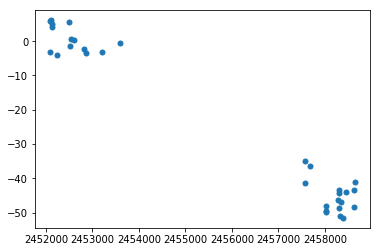

In [5]:
ndata = pd.read_csv('../rvdata/vst213472_june10.csv')
ndata['jd'] = ndata['bjd']
ndata['mnvel'] -= 45
ndata = ndata.sort_values('jd') #Sort by time of observation.
fig, ax = plt.subplots()
ax.scatter(ndata['jd'], ndata['mnvel'])

In [6]:
ntime = np.asarray(ndata.jd)
nmnvel = np.asarray(ndata.mnvel)
nerrvel = np.asarray(ndata.errvel)

#Use correct units for RVs. Time is in days for TheJoker.
ntime   *= u.day
nmnvel  *= u.m/u.s
nerrvel *= u.m/u.s

In [7]:
#Average jitter terms for post/pre-upgrade HIRES, from RadVel estimate.
njitter = 0.5*(post.params['jit_k'].value + post.params['jit_j'].value)*u.m/u.s
nrvdata = RVData(t=ntime, rv=nmnvel, stddev=nerrvel)
nbaseline = np.amax(ntime) - np.amin(ntime)

In [8]:
print(nbaseline, P_one)

6550.078565330245 d 43456.00986158163


In [9]:
nparams = JokerParams(P_min=nbaseline, P_max=20*nbaseline)#P_max=3*P_one*u.day)
njoker = TheJoker(nparams)
nsamples = njoker.rejection_sample(nrvdata, n_prior_samples=2*10**8)

INFO: 718 good samples after rejection sampling [thejoker.sampler.sampler]


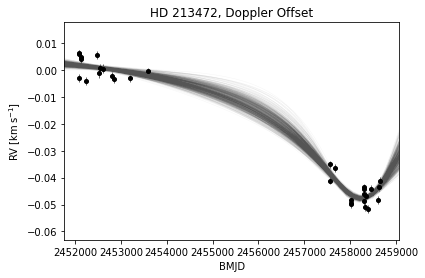

In [10]:
fig = plot_rv_curves(nsamples, data=nrvdata)
ax = fig.axes[0]
ax.set_title('HD 213472, Doppler Offset')
fig.savefig('Joker_tests/213472_orbit_dopploff.pdf')

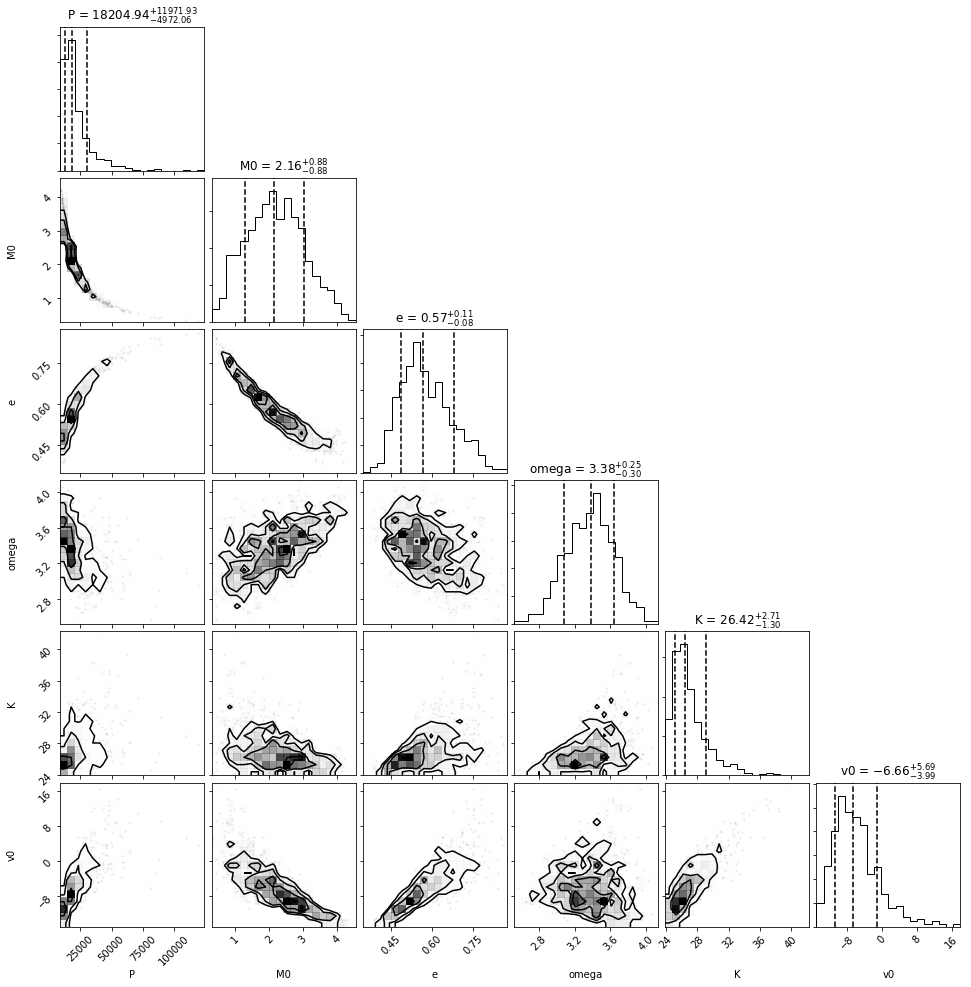

In [11]:
P = np.array(nsamples['P']/nsamples['P'].unit)
M0 = np.array(nsamples['M0']/nsamples['M0'].unit)
e = np.array(nsamples['e']/nsamples['e'].unit)
omega = np.array(nsamples['omega']/nsamples['omega'].unit)
jitter = np.array(nsamples['jitter']/nsamples['jitter'].unit)
K = np.array(nsamples['K']/nsamples['K'].unit)
v0 = np.array(nsamples['v0']/nsamples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('Joker_tests/213472_chains_dopploff.csv')

fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('Joker_tests/213472_corner_dopploff.pdf')

## Do the same, for HD 111031.

In [3]:
data11 = pd.read_csv('../rvdata/vst111031.csv')
data11['jd'] = data11['bjd']
data11 = data11.sort_values('jd')

In [4]:
time = np.asarray(data11.jd)
mnvel = np.asarray(data11.mnvel)
errvel = np.asarray(data11.errvel)

#Use correct units for RVs. Time is in days for TheJoker.
time   *= u.day
mnvel  *= u.m/u.s
errvel *= u.m/u.s

In [5]:
rvdata = RVData(t=time, rv=mnvel, stddev=errvel)
baseline = np.amax(time) - np.amin(time)

params = JokerParams(P_min=baseline, P_max=20*baseline)
joker = TheJoker(params)
samples = joker.rejection_sample(rvdata, n_prior_samples=10**8)

INFO: 972 good samples after rejection sampling [thejoker.sampler.sampler]


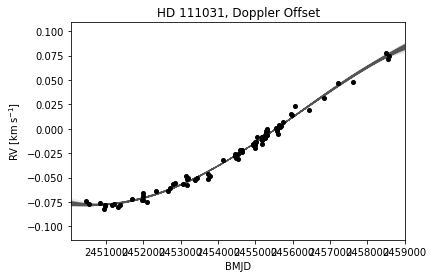

In [6]:
fig = plot_rv_curves(samples, data=rvdata)
ax = fig.axes[0]
ax.set_title('HD 111031, Doppler Offset')
fig.savefig('Joker_tests/111031_orbit_dopploff.pdf')

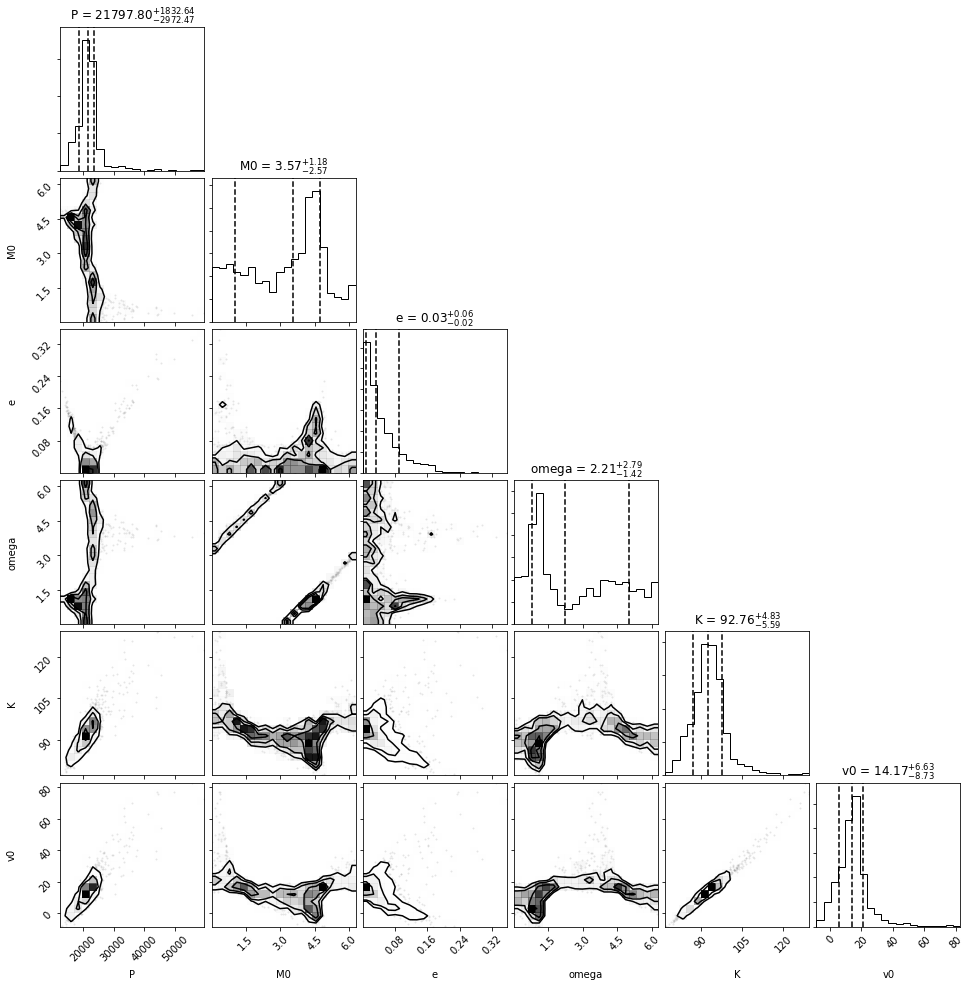

In [7]:
P = np.array(samples['P']/samples['P'].unit)
M0 = np.array(samples['M0']/samples['M0'].unit)
e = np.array(samples['e']/samples['e'].unit)
omega = np.array(samples['omega']/samples['omega'].unit)
jitter = np.array(samples['jitter']/samples['jitter'].unit)
K = np.array(samples['K']/samples['K'].unit)
v0 = np.array(samples['v0']/samples['v0'].unit)

jchains = pd.DataFrame.from_dict({'P':P, 'M0':M0, 'e':e, 'omega':omega, 'K':K, 'v0':v0})
jchains.to_csv('Joker_tests/111031_chains_dopploff.csv')

fig = corner.corner(jchains, labels=['P', 'M0', 'e', 'omega', 'K', 'v0'],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                    title_kwargs={"fontsize": 12})
fig.savefig('Joker_tests/111031_corner_dopploff.pdf')

In [8]:
baseline

<Quantity 8105.7169004 d>